<a href="https://colab.research.google.com/github/Cosmobyte/WasteWEcycling/blob/main/WasteWecycling_AI_model_(Caroline).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.4 MB/s 
     |████████████████████████████████| 1.2 MB 34.5 MB/s 
     |████████████████████████████████| 46 kB 4.0 MB/s 
     |████████████████████████████████| 189 kB 53.1 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
     |████████████████████████████████| 51 kB 323 kB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *

Source of images:

https://www.kaggle.com/mostafaabla/garbage-classification

### Import data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/gdrive/MyDrive/TechLabs/garbage_classification.zip', 'r') # Opens the zip file in read mode
zip_ref.extractall('/tmp') # Extracts the files into the /tmp folder
zip_ref.close()

In [5]:
# Number of files in imported zip file
len(os.listdir('/tmp/garbage_classification'))

15516

In [7]:
path = Path('/tmp/garbage_classification')
Path.BASE_PATH = path

In [8]:
# Show image files
fns = get_image_files(path)
fns

(#15515) [Path('clothes264.jpg'),Path('white-glass126.jpg'),Path('battery68.jpg'),Path('white-glass653.jpg'),Path('trash229.jpg'),Path('battery580.jpg'),Path('white-glass373.jpg'),Path('clothes5199.jpg'),Path('battery828.jpg'),Path('trash199.jpg')...]

In [9]:
# Show folders
path.ls()

(#15516) [Path('clothes264.jpg'),Path('white-glass126.jpg'),Path('battery68.jpg'),Path('white-glass653.jpg'),Path('trash229.jpg'),Path('battery580.jpg'),Path('white-glass373.jpg'),Path('clothes5199.jpg'),Path('battery828.jpg'),Path('trash199.jpg')...]

### Label data

In [10]:
# Show example of images in folder
#(path/"white-glass").ls()

In [11]:
# Try extracting category from file name with regex expression
fname = (path).ls()[0]
re.findall(r'(^\D+)\d+.jpg$', fname.name)

['clothes']

In [12]:
# Create dataloaders with regex expression 
garbage = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 get_y=using_attr(RegexLabeller(r'(^\D+)\d+.jpg$'), 'name'),
                 splitter=RandomSplitter(seed=42),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = garbage.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


In [13]:
# Check the labels
dls.vocab

['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

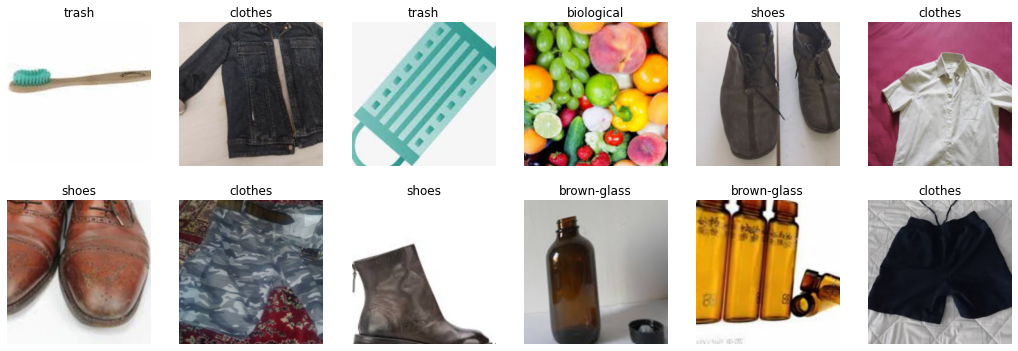

In [14]:
# Show some of the images with labels
dls.train.show_batch(max_n=12, nrows=2)

### Train model

In [26]:
# Create a CNN learner using resnet34
learn = cnn_learner(dls, resnet34, metrics=error_rate)

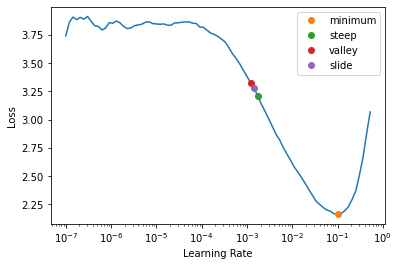

In [27]:
# Find learning rate
# https://forums.fast.ai/t/new-lr-finder-output/89236/3
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide = lrs.minimum, lrs.steep, lrs.valley, lrs.slide

In [28]:
# Train the model using fit_one_cycle
learn.fit_one_cycle(n_epoch=3, lr_max=lr_valley)

epoch,train_loss,valid_loss,error_rate,time
0,0.515937,0.206047,0.061231,04:07
1,0.283953,0.158823,0.053819,04:07
2,0.209663,0.142361,0.048985,04:06


After only 3 epochs, we can achieve ≈95% accuracy.

In [29]:
# Now we unfreeze the network 
learn.unfreeze()

SuggestedLRs(minimum=1.9054607491852948e-07, steep=6.309573450380412e-07, valley=0.00015848931798245758, slide=4.365158383734524e-05)

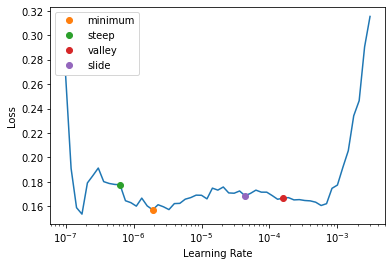

In [30]:
# run lr_find again, because having more layers to train, and weights that have already been trained for three epochs, means our previously found learning rate isn't appropriate any more
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#lr_min, lr_steep, lr_valley, lr_slide = lrs.minimum, lrs.steep, lrs.valley, lrs.slide

In [31]:
# Now we can train the whole network
learn.fit_one_cycle(n_epoch=12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.184789,0.136429,0.045440,05:27
1,0.163543,0.126453,0.040606,05:27
2,0.158469,0.119296,0.036416,05:27
3,0.121695,0.114309,0.033194,05:27
4,0.107603,0.111470,0.031582,05:27
5,0.100179,0.104705,0.030293,05:27
6,0.080826,0.103268,0.029649,05:27
7,0.072572,0.101775,0.029649,05:28
8,0.064639,0.098683,0.029649,05:27
9,0.064585,0.097932,0.030293,05:27


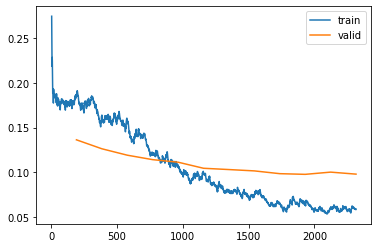

In [32]:
learn.recorder.plot_loss()

In [ ]:
# Try a deeper model
#from fastai.callback.fp16 import *
#learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
#learn.fine_tune(6, freeze_epochs=3)

### Check data and predictions

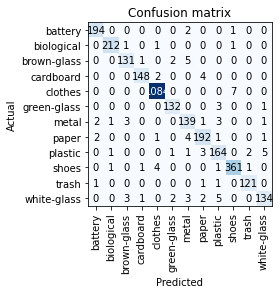

In [33]:
# Confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

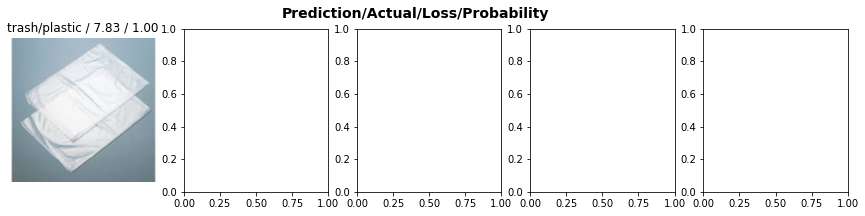

In [34]:
# Showing top losses
interp.plot_top_losses(5, nrows=1)

In [ ]:
# Clean data, if neccessary
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

### Turning the model into an application

In [35]:
# Exporting the model (architecture and parameters)
learn.export()
# Checking that the export file exists
# This file is needed wherever you deploy your app to.
path = Path()
path.ls(file_exts='.pkl')

# OBS: If using this for deployment with binder, then save the export.pkl file locally and upload it to GitHub.
# See this: https://medium.com/unpackai/how-to-deploy-fast-ai-models-8704ea711ad2

(#1) [Path('export.pkl')]

In [36]:
# To create our inference learner from the exported file, we use load_learner
learn_inf = load_learner(path/'export.pkl')

In [53]:
# Create classification button
btn_run = widgets.Button(description='Classify')
# Create uploading image
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [56]:
# Grabbing the image
img = PILImage.create(btn_upload.data[-1])

# Outputting the image
out_pl = widgets.Output()

In [58]:
# Get predictions
pred,pred_idx,probs = learn_inf.predict(img)

# Display predictions with labels
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: plastic; Probability: 0.8327')

In [54]:
# Create Click event handler
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [59]:
# Putting everything in a vertical box
VBox([widgets.Label('Upload image of waste'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning the notebook into a real app

In [61]:
# Installing IPython and Voila
#!pip install voila
#!jupyter serverextension enable --sys-prefix voila 

To publish your web app on [Binder](https://mybinder.org/), you follow these steps:

1. Add your notebook to a [GitHub repository](http://github.com/).
2. Paste the URL of that repo into Binder's URL, as shown in <<deploy-binder>>.
3. Change the File dropdown to instead select URL.
4. In the "URL to open" field, enter `/voila/render/name.ipynb` (replacing `name` with the name of for your notebook).
5. Click the clickboard button at the bottom right to copyt the URL and paste it somewhere safe. 
6. Click Launch.